In [4]:

from __future__ import print_function

import sys

# sys.path.extend(['/home/jogi/git/repository/dcnn_acdc'])
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm


from datetime import datetime
from pytz import timezone
import itertools
import copy

import SimpleITK as sitk
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from config.config import config
from utils.experiment import Experiment, ExperimentHandler
from utils.batch_handlers import TwoDimBatchHandler
from utils.test_handler import ACDC2017TestHandler, test_ensemble
from plotting.learning_curves import loss_plot
from plotting.uncertainty_plots import analyze_slices
from plotting.slice_outliers_plots import plot_outlier_slice_hists

from models.dilated_cnn import BaseDilated2DCNN

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"
LOG_DIR = os.path.join(ROOT_DIR, "logs")
CYCLE_OFFSET = 100000
# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
np.random.seed(SEED)

# IMPORTANT - THE FOLD WE'RE USING FOR TESTING. NOTE: Training and testing fold should be the same
# we raise an error in the test_ensemble method if this is not the case!
TEST_FOLD = 0

# baseline: 
# exp_base = {2: "20180328_10_53_16_dcnnv1_150000E_lr2e02",
#            0: "20180330_09_56_39_dcnnv1_150000E_lr2e02"}
# exp_base_model = os.path.join(LOG_DIR, exp_base[TEST_FOLD])

# MC dropout models
# Fold 2: 
# Fold 0: 20180413_16_36_58_dcnn_mcv1_150000E_lr2e02
exp_mc005 = {2: "",
             0: "20180413_16_36_58_dcnn_mcv1_150000E_lr2e02"}
exp_mc005_model = os.path.join(LOG_DIR, exp_mc005[TEST_FOLD])

# Fold 2: 
# Fold 0: 20180416_08_25_43_dcnn_mcv1_150000E_lr2e02
# exp_mc01 = {2: "",
#            0: "20180416_08_25_43_dcnn_mcv1_150000E_lr2e02"}
# exp_mc01_model = os.path.join(LOG_DIR, exp_mc01[TEST_FOLD])

# Fold 2: 
# Fold 0: 20180413_17_03_22_dcnn_mcv1_150000E_lr2e02
exp_mc005_g1000 = {2: "",
                   0: "20180413_17_03_22_dcnn_mcv1_150000E_lr2e02"}
exp_mc005_g1000_model = os.path.join(LOG_DIR, exp_mc005_g1000[TEST_FOLD])

# Fold 2: 
# Fold 0: 20180413_17_03_46_dcnn_mcv1_150000E_lr2e02
exp_mc005_g2000 = {2: "",
                   0: "20180413_17_03_46_dcnn_mcv1_150000E_lr2e02"}
exp_mc005_g2000_model = os.path.join(LOG_DIR, exp_mc005_g2000[TEST_FOLD])

# Fold 2: 
# Fold 0: 20180415_16_04_41_dcnn_mcv1_150000E_lr2e02
exp_mc005_g5000 = {2: "",
                   0: "20180415_16_04_41_dcnn_mcv1_150000E_lr2e02"}
exp_mc005_g5000_model = os.path.join(LOG_DIR, exp_mc005_g5000[TEST_FOLD])

# Fold 2: 
# Fold 0: 20180414_20_20_49_dcnn_mcv1_150000E_lr2e02
exp_mc005_g10000 = {2: "",
                   0: "20180414_20_20_49_dcnn_mcv1_150000E_lr2e02"}
exp_mc005_g10000_model = os.path.join(LOG_DIR, exp_mc005_g10000[TEST_FOLD])

In [6]:
exper_mc005 = ExperimentHandler.load_experiment(exp_mc005_model)
exper_hdl_mc005 = ExperimentHandler(exper_mc005, use_logfile=False)
exper_hdl_mc005.set_root_dir(ROOT_DIR)
exper_hdl_mc005.set_model_name("MC-dropout fold-{} (p={})".format(exper_hdl_mc005.exper.run_args.fold_ids[0],
    exper_hdl_mc005.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc005.exper.model_name))

exper_mc005_g1000 = ExperimentHandler.load_experiment(exp_mc005_g1000_model)
exper_hdl_mc005_g1000 = ExperimentHandler(exper_mc005_g1000, use_logfile=False)
exper_hdl_mc005_g1000.set_root_dir(ROOT_DIR)
exper_hdl_mc005_g1000.set_model_name("MC-dropout-g{} fold-{} (p={})".format(
                                     exper_hdl_mc005_g1000.exper.run_args.chkpnt_freq,
                                     exper_hdl_mc005_g1000.exper.run_args.fold_ids[0],
                                     exper_hdl_mc005_g1000.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc005_g1000.exper.model_name))

exper_mc005_g2000 = ExperimentHandler.load_experiment(exp_mc005_g2000_model)
exper_hdl_mc005_g2000 = ExperimentHandler(exper_mc005_g2000, use_logfile=False)
exper_hdl_mc005_g2000.set_root_dir(ROOT_DIR)
exper_hdl_mc005_g2000.set_model_name("MC-dropout-g{} fold-{} "
                                     "(p={})".format(exper_hdl_mc005_g2000.exper.run_args.chkpnt_freq,
                                         exper_hdl_mc005_g2000.exper.run_args.fold_ids[0],
                                     exper_hdl_mc005_g2000.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc005_g2000.exper.model_name))

exper_mc005_g5000 = ExperimentHandler.load_experiment(exp_mc005_g5000_model)
exper_hdl_mc005_g5000 = ExperimentHandler(exper_mc005_g5000, use_logfile=False)
exper_hdl_mc005_g5000.set_root_dir(ROOT_DIR)
exper_hdl_mc005_g5000.set_model_name("MC-dropout-g{} fold-{} "
                                     "(p={})".format(exper_hdl_mc005_g5000.exper.run_args.chkpnt_freq,
                                     exper_hdl_mc005_g5000.exper.run_args.fold_ids[0],
                                     exper_hdl_mc005_g5000.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc005_g5000.exper.model_name))

exper_mc005_g10000 = ExperimentHandler.load_experiment(exp_mc005_g10000_model)
exper_hdl_mc005_g10000 = ExperimentHandler(exper_mc005_g10000, use_logfile=False)
exper_hdl_mc005_g10000.set_root_dir(ROOT_DIR)
exper_hdl_mc005_g10000.set_model_name("MC-dropout-g{} fold-{} "
                                     "(p={})".format(exper_hdl_mc005_g10000.exper.run_args.chkpnt_freq,
                                         exper_hdl_mc005_g10000.exper.run_args.fold_ids[0],
                                     exper_hdl_mc005_g10000.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc005_g10000.exper.model_name))

Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180413_16_36_58_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Model name MC-dropout fold-0 (p=0.05)
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180413_17_03_22_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Model name MC-dropout-g1000 fold-0 (p=0.05)
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180413_17_03_46_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Model name MC-dropout-g2000 fold-0 (p=0.05)
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180415_16_04_41_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Model name MC-dropout-g5000 fold-0 (p=0.05)
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180414_20_20_49_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Model name MC-dropout-g10000 fold-0 (p=0.05)


[ 4  8 11 11 29  2  2  1  2  2  2  1]
[ 6  7  8  9 10 11 12 13 14 15 16 17]


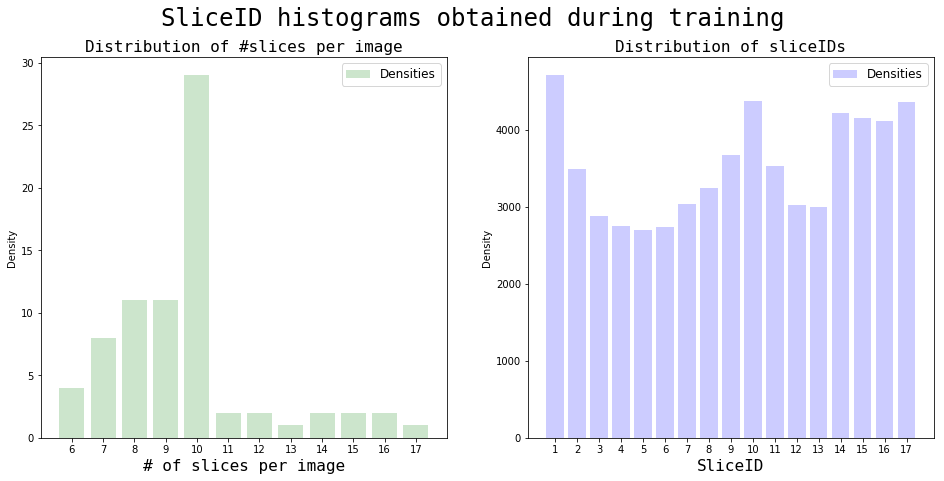

In [7]:
exper_hdl_mc005_g10000.exper.batch_stats.compute_slice_histogram()
exper_hdl_mc005_g10000.exper.batch_stats.plot_histgrams(width=16, height=7, do_show=True)

Loaded outlier stats for 30 training epochs (property=outliers_per_epoch, dictionary with tuple)


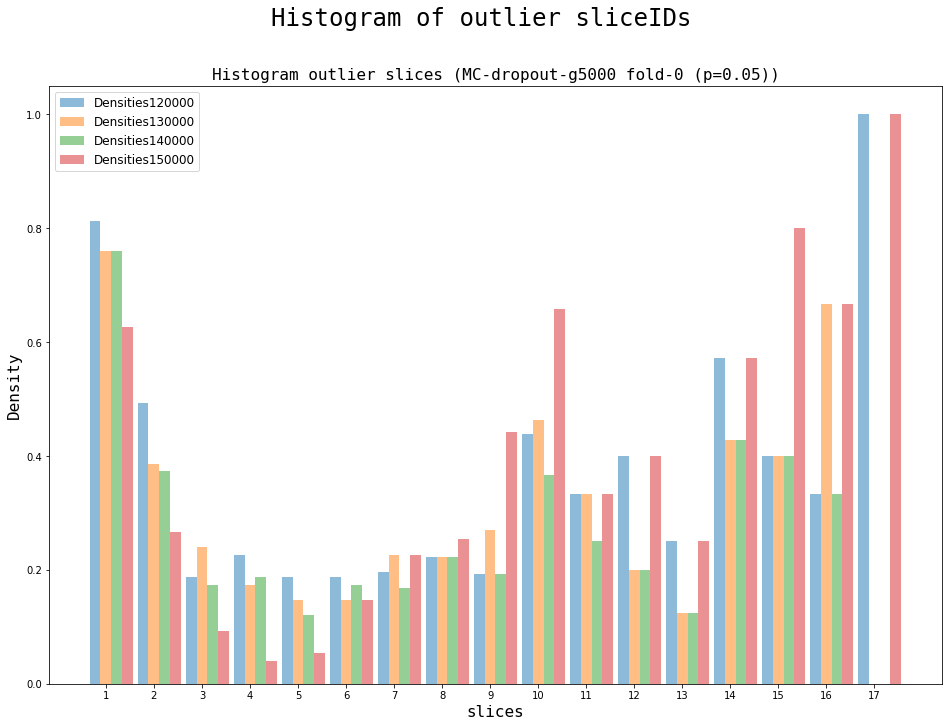

In [7]:


exper_hdl_mc005_g5000.exper.batch_stats.compute_slice_histogram()
exper_hdl_mc005_g5000.get_outlier_stats()
plot_outlier_slice_hists(exper_hdl_mc005_g5000.exper, do_show=True, epochs=[120000, 130000, 140000, 150000])

In [ ]:
from plotting.learning_curves import plot_dice_normal_outliers

plot_dice_normal_outliers(exper_hdl_mc005_g5000.exper, height=14, do_show=True, do_average=True,
                          epoch_range=[130000, 140000], statistic="dice_coeff", include_outliers=True, do_save=True)



